I utilized the SVM implementation specifically tailored for EEG data from the following GitHub repository: https://github.com/jayavardhanravi/EEG-Data-predection/blob/master/mypart1.py. This resource provided invaluable support for my SVM analysis.

# Final Notebook SVM

In [ ]:
pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import packages

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import mne
import os
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_multitaper
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedGroupKFold
%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

# Load in FAA data

In [ ]:
df_features = pd.read_pickle('/content/drive/MyDrive/TD-BRAIN/extracted_features/df_stat_features.pkl') ## calculated FAA
df_features['age'] = df_features['age'].round().astype('Int32') # round age to nearest year and convert to int
df_features = df_features.dropna(subset=['diagnosis'])
df_features.sample(7)

,ID,age,gender,diagnosis,epoch,Fp2-Fp1_eo,F8-F7_eo,F4-F3_eo,FC4-FC3_eo,Fp2-Fp1_ec,F8-F7_ec,F4-F3_ec,FC4-FC3_ec
2673,sub-88048953,56,0.0,MDD,10,1.629851e+11,-7.236232e+10,1.053389e+11,2.585918e+09,2.807696e+11,-3.640870e+11,-6.487291e+10,-3.519739e+11
351,sub-88000313,35,0.0,MDD,4,-4.363567e+11,-2.053686e+11,-7.086938e+11,-9.597405e+11,-1.070383e+12,-1.494221e+12,-8.877785e+11,-6.257641e+11
3474,sub-88065241,56,1.0,MDD,7,4.416579e+10,2.070978e+11,-1.381225e+10,-1.215461e+11,6.646099e+11,5.978771e+11,8.186702e+11,1.393638e+12
3265,sub-88060249,55,0.0,MDD,2,2.055683e+11,-1.449243e+11,3.640012e+11,4.299053e+11,9.889461e+11,2.409110e+12,2.382675e+12,3.213405e+12
407,sub-88002789,39,0.0,MDD,12,-2.413960e+11,-3.269383e+10,-5.572659e+11,-2.459681e+11,6.984796e+11,1.494122e+12,1.180425e+12,1.767714e+12
3377,sub-88062545,50,1.0,MDD,6,5.650067e+11,5.782061e+10,7.021820e+11,4.609942e+11,8.632763e+10,3.998585e+10,-2.132754e+11,-2.349822e+11
3662,sub-88068213,61,0.0,MDD,3,1.630317e+09,1.558210e+11,3.708025e+09,1.716457e+11,-3.925277e+11,-1.276297e+12,-1.188264e+12,-9.279557e+11


# Rebalance data due to unbalanced dataset

In [ ]:
 # subsample dataset to rebalance dataset
df_ids = df_features[(df_features['epoch'] == 1)] # select only first epoch to make sure, I subsample from participants, and not from epochs
df_ids_subsample = df_ids.groupby('diagnosis').sample(47, random_state=42) # sample 47 participants per diagnosis (which is the max for HEALTHY)
df_ids_subsample_index = df_ids_subsample['ID'].tolist()
df_subsample = df_features[(df_features['ID'].isin(df_ids_subsample_index))]
df_subsample['diagnosis'].value_counts()

diagnosis
HEALTHY    564
MDD        564
Name: count, dtype: int64

In [ ]:
# Create Feature Sets for EO and EC
df_features_ec = df_subsample[df_features.columns[~df_features.columns.str.startswith('eo')]]
df_features_eo = df_subsample[df_features.columns[~df_features.columns.str.startswith('ec')]]

# Set the channels

In [ ]:
# channel groupings for frontal alpha asymmetry
frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4']
channel_groups = {'frontal': frontal}

In [ ]:
# define frequencies of interest for frontal alpha band
alpha = np.array([8, 9, 10, 11, 12])
bands = {'alpha': alpha}

# SVM

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

# Load in df_features_ec
groups = df_subsample['ID'].tolist()
print(f'Total number of instances: {len(groups)}')

# Define numeric and categorical columns
numeric_cols = ['Fp2-Fp1_ec', 'F8-F7_ec', 'F4-F3_ec', 'FC4-FC3_ec', 'Fp2-Fp1_eo', 'F8-F7_eo', 'F4-F3_eo', 'FC4-FC3_eo']
categorical_cols = ['gender']

X = df_subsample[numeric_cols + categorical_cols]
Y = df_subsample['diagnosis']

# Encode the labels
le = LabelBinarizer()
Y = le.fit_transform(Y)

# Reshape Y
Y = Y.ravel()

# Preprocessing steps for numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Standardization
    ('impute', SimpleImputer(strategy='mean'))  # Mean imputation for numeric columns
])

# Preprocessing steps for the categorical feature
categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent'))  # Imputing missing values with the most frequent value
])

# Combine numeric and categorical transformers
col_trans = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_cols),
        ('categorical_transformer', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

# Define the SVM model
svm = SVC(class_weight='balanced')

# Define the pipeline without PCA
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('svm', svm)
])

param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedGroupKFold(n_splits=5), scoring='accuracy')

# Split data into training and validation sets
cv_outer = StratifiedGroupKFold(n_splits=5, shuffle=True)
for i, (train_indices, val_indices) in enumerate(cv_outer.split(X, Y, groups=groups)):
    X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
    Y_train, Y_val = Y[train_indices], Y[val_indices]

    # Fit the GridSearchCV on training data
    grid_search.fit(X_train, Y_train)

    # Get the best estimator
    best_model = grid_search.best_estimator_

    # Evaluate on training set
    Y_pred_train = best_model.predict(X_train)
    accuracy_train = accuracy_score(Y_train, Y_pred_train)

    # Evaluate on validation set
    Y_pred_val = best_model.predict(X_val)
    accuracy_val = accuracy_score(Y_val, Y_pred_val)
    f1_score_val = f1_score(Y_val, Y_pred_val, average='weighted')
    precision_val = precision_score(Y_val, Y_pred_val, average='weighted')
    recall_val = recall_score(Y_val, Y_pred_val, average='weighted')
    confusion_matrix_val = confusion_matrix(Y_val, Y_pred_val)

    print(f"Fold {i}:")
    print(f"Best C parameter: {grid_search.best_params_['svm__C']}")
    print(f"Training Accuracy: {accuracy_train}")
    print(f"Validation Accuracy: {accuracy_val}")
    print(f"Training Precision: {precision_score(Y_train, Y_pred_train, average='weighted')}")
    print(f"Validation Precision: {precision_val}")
    print(f"Training Recall: {recall_score(Y_train, Y_pred_train, average='weighted')}")
    print(f"Validation Recall: {recall_val}")
    print(f"Training F1 Score: {f1_score(Y_train, Y_pred_train, average='weighted')}")
    print(f"Validation F1 Score: {f1_score_val}")
    print("Confusion Matrix:")
    print(confusion_matrix_val)

Total number of instances: 1128
Fold 0:
Training Accuracy: 0.5644444444444444
Validation Accuracy: 0.4692982456140351
Training Precision: 0.568021077681455
Validation Precision: 0.46019811433345265
Training Recall: 0.5644444444444444
Validation Recall: 0.4692982456140351
Training F1 Score: 0.56099908351605
Validation F1 Score: 0.45822421221593307
Confusion Matrix:
[[73 47]
 [74 34]]
Fold 1:
Training Accuracy: 0.5577777777777778
Validation Accuracy: 0.5131578947368421
Training Precision: 0.5624915635545557
Validation Precision: 0.5053584186711122
Training Recall: 0.5577777777777778
Validation Recall: 0.5131578947368421
Training F1 Score: 0.5561147946561108
Validation F1 Score: 0.508101192207037
Confusion Matrix:
[[35 61]
 [50 82]]
Fold 2:
Training Accuracy: 0.5911111111111111
Validation Accuracy: 0.4166666666666667
Training Precision: 0.5910386085854084
Validation Precision: 0.4192799070847851
Training Recall: 0.5911111111111111
Validation Recall: 0.4166666666666667
Training F1 Score: 0

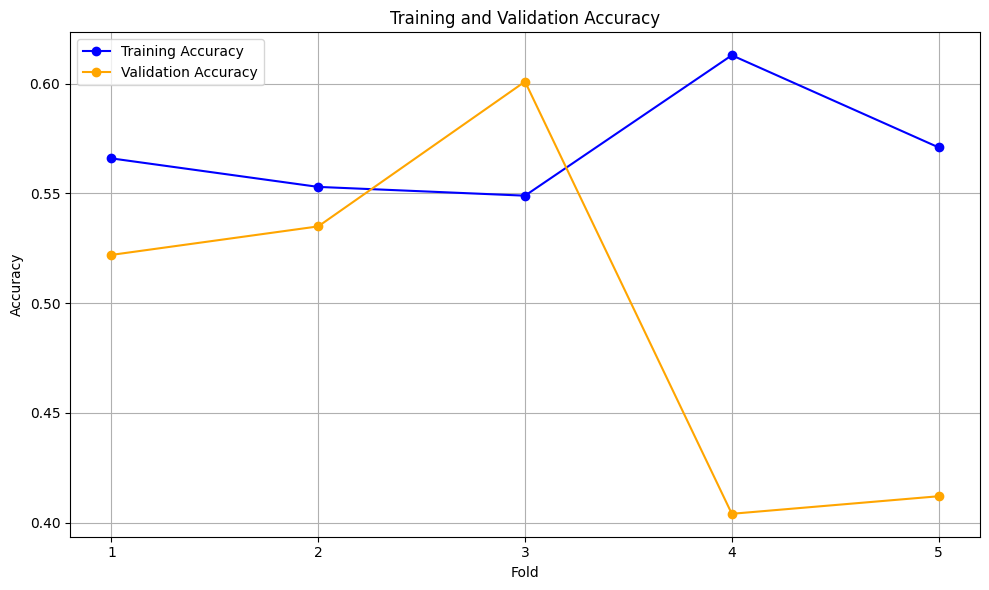

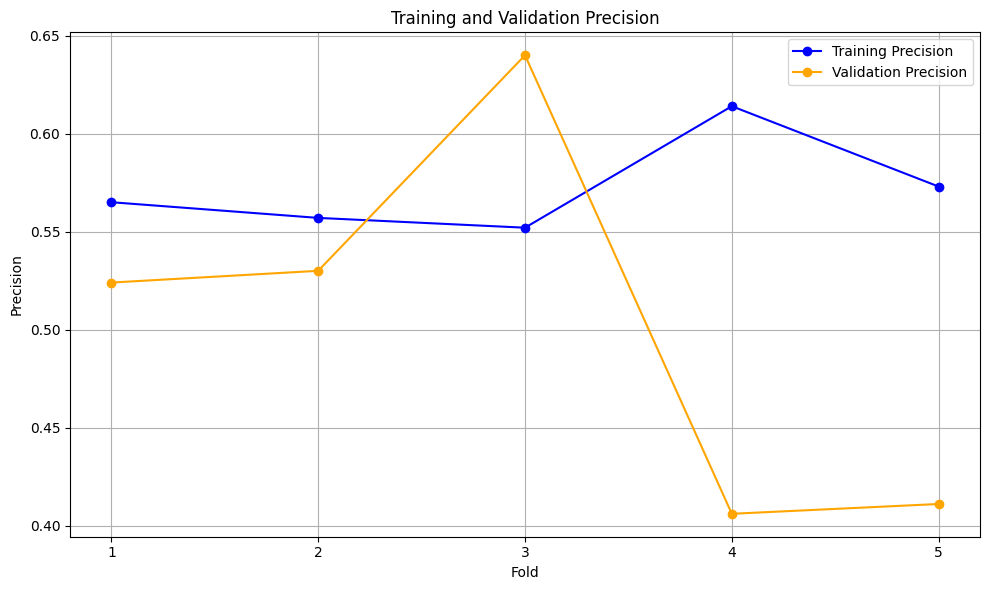

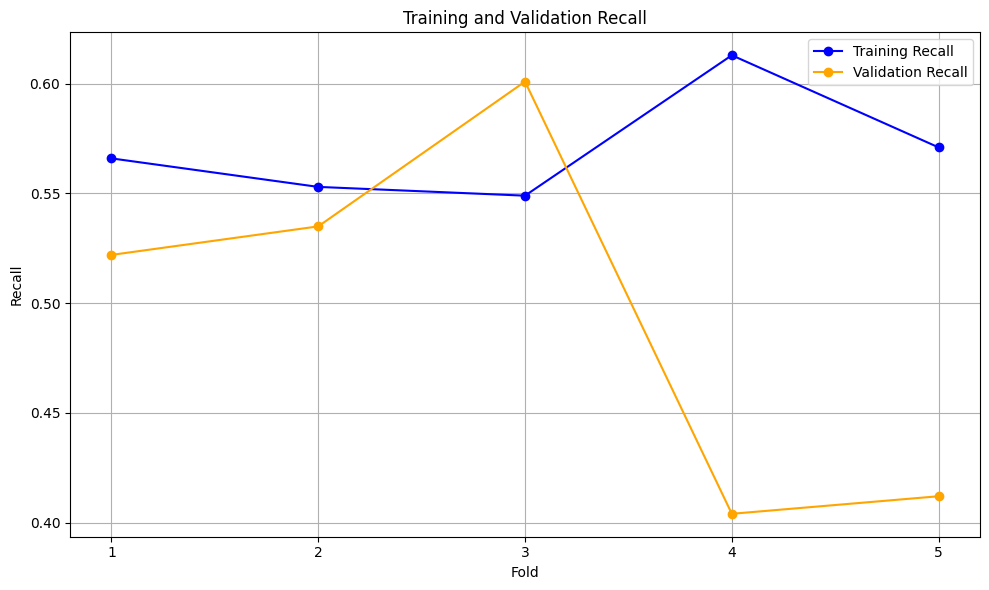

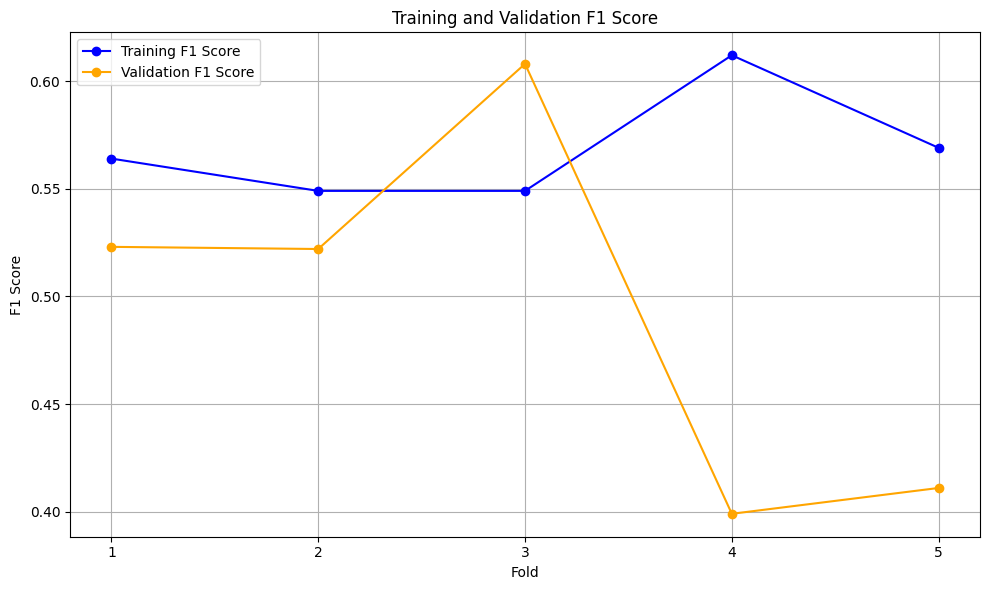

In [ ]:
import matplotlib.pyplot as plt

# Results for each fold
folds = range(1, 6)

# Training and validation results for each metric
accuracy_train = [0.566, 0.553, 0.549, 0.613, 0.571]
accuracy_val = [0.522, 0.535, 0.601, 0.404, 0.412]
precision_train = [0.565, 0.557, 0.552, 0.614, 0.573]
precision_val = [0.524, 0.530, 0.640, 0.406, 0.411]
recall_train = [0.566, 0.553, 0.549, 0.613, 0.571]
recall_val = [0.522, 0.535, 0.601, 0.404, 0.412]
f1_train = [0.564, 0.549, 0.549, 0.612, 0.569]
f1_val = [0.523, 0.522, 0.608, 0.399, 0.411]

# Plotting each metric
plt.figure(figsize=(10, 6))

# Training and validation accuracy
plt.plot(folds, accuracy_train, marker='o', linestyle='-', color='blue', label='Training Accuracy')
plt.plot(folds, accuracy_val, marker='o', linestyle='-', color='orange', label='Validation Accuracy')

# Labels and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(folds)
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Plotting training and validation precision
plt.figure(figsize=(10, 6))

plt.plot(folds, precision_train, marker='o', linestyle='-', color='blue', label='Training Precision')
plt.plot(folds, precision_val, marker='o', linestyle='-', color='orange', label='Validation Precision')

plt.title('Training and Validation Precision')
plt.xlabel('Fold')
plt.ylabel('Precision')
plt.xticks(folds)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting training and validation recall
plt.figure(figsize=(10, 6))

plt.plot(folds, recall_train, marker='o', linestyle='-', color='blue', label='Training Recall')
plt.plot(folds, recall_val, marker='o', linestyle='-', color='orange', label='Validation Recall')

plt.title('Training and Validation Recall')
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.xticks(folds)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting training and validation F1 score
plt.figure(figsize=(10, 6))

plt.plot(folds, f1_train, marker='o', linestyle='-', color='blue', label='Training F1 Score')
plt.plot(folds, f1_val, marker='o', linestyle='-', color='orange', label='Validation F1 Score')

plt.title('Training and Validation F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.xticks(folds)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
